# Backtest of Systematic Yield Curve Trading Strategy

### Brief Description
The aim of this document is to backtest a systematic fixed income relative value strategy for Mexican Government Peso-denominated bonds (MBONOs). The strategy seeks to capitalize on mispricings along the yield curve and across bond maturities. These dislocations arise from supply-demand imbalances, often caused by market fragmentation and the capital or regulatory constraints faced by liquidity providers. In particular, emerging markets sometimes lack arbitrage capital, allowing well-capitalized traders to exploit these inefficiencies.

The strategy implementation consists of four key elements:

1. Identification of mispriced relationships or parts of the curve and modeling their behavior.
2. Portfolio construction that isolates alpha while minimizing market risk.
3. Instrument selection and trade execution to achieve the desired position profile in the most efficient way.
4. Risk management overlay to appropriately size positions, ensuring the best risk/return profile.

I utilize the tools and procedures from [my repository](https://github.com/akaufman22/mbono-firv), where all required inputs are calculated from scratch based on a historical dataset of raw market prices for Mexican government bonds.

The assumptions and mechanics of the strategy are discussed throughout the document.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import QuantLib as ql

from src.mbonofirv.systematic.signals import MeanReversionSignal, AggregatedSignal
from src.mbonofirv.systematic.strategies import SystematicStrategy

from src.mbonofirv.systematic.estimation import (load_historical_data,
                                                 generate_spread_signals,
                                                 generate_triplet_signals,
                                                 plot_stats)

plt.style.use('ggplot')

Global constants for MBONO market:

In [2]:
CONVENTION = ql.Unadjusted
CALENDAR = ql.Mexico()
YIELD_BASIS = ql.Semiannual
TENOR = ql.Period(ql.Semiannual)
RULE = ql.DateGeneration.Backward
DAY_COUNT = ql.Actual360()
SETTLEMENT_DAYS = 2

Loading and preparing the data: defining instument objects, loading zero curves, market prices, curve fit metrics etc

In [3]:
df_zc, df, price_data, fit_data = load_historical_data(print_head=True)

Curves


,Y1,Y2,Y3,Y5,Y7,Y10,Y15,Y20,Y30
Date,,,,,,,,,
2010-01-01 00:00:00,0.049139,0.059082,0.066124,0.074606,0.079008,0.082525,0.086468,0.090251,0.096812
2010-01-04 00:00:00,0.048706,0.059136,0.066494,0.075229,0.079574,0.082800,0.086405,0.090291,0.097765
2010-01-05 00:00:00,0.051110,0.058690,0.066621,0.075089,0.079097,0.082451,0.086078,0.089435,0.098320
2010-01-06 00:00:00,0.050152,0.059206,0.066920,0.074806,0.078709,0.082246,0.086287,0.089779,0.097143
2010-01-07 00:00:00,0.048686,0.059434,0.066632,0.074840,0.078968,0.082336,0.086170,0.089791,0.096544


Instruments


,InstrumentID,Maturity,PricingDate,QL bond
BBGID,,,,
EC4262522 Corp,6,2011-07-14 00:00:00,2001-07-20 00:00:00,*' at 0x7fc406fefa20> >
EC6223613 Corp,10,2009-07-09 00:00:00,2002-07-12 00:00:00,*' at 0x7fc406fef030> >
EC8045386 Corp,12,2009-12-24 00:00:00,2002-12-27 00:00:00,*' at 0x7fc406fef3f0> >
EC8084633 Corp,13,2012-12-20 00:00:00,2003-01-03 00:00:00,*' at 0x7fc406ff8960> >
ED2028832 Corp,15,2023-12-07 00:00:00,2003-10-24 00:00:00,*' at 0x7fc406ff81e0> >


Prices


,EC4262522 Corp,EC8045386 Corp,EC8084633 Corp,ED2028832 Corp,ED2746086 Corp,ED2816525 Corp,ED7597518 Corp,ED7791103 Corp,ED7894840 Corp,EF2270975 Corp,EF5478096 Corp,EF5805942 Corp,EF7918115 Corp,EG1116375 Corp,EG1429968 Corp,EG6663686 Corp,EH1850997 Corp,EH6834517 Corp,EH6944449 Corp,EH7175118 Corp,EH9108950 Corp,EI1588082 Corp,EI3157795 Corp,EI5616079 Corp,EI7570381 Corp,EI8047355 Corp,BO5734625 Corp,BO5786427 Corp,EJ0234298 Corp,EJ1291206 Corp,EJ2827917 Corp,EJ8068490 Corp,EK1693424 Corp,EI7361336 Corp,QJ1649335 Corp,AM7523740 Corp,AS2511341 Corp,AX6352725 Corp,ZR8833868 Corp,BR4592233 Corp,BS4948482 Corp,BX4963407 Corp
Date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2010-01-01 00:00:00,108.040000,100.011000,106.456000,97.457000,102.788000,103.646000,109.157000,114.879000,106.560000,102.930000,106.430000,104.380000,113.645000,91.109000,97.763000,102.350000,99.320000,99.151000,97.116000,103.246000,98.980000,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
2010-01-04 00:00:00,108.045000,100.011000,106.240000,97.553000,102.804000,103.390000,108.919000,114.605000,106.521000,102.383000,106.486000,104.404000,113.361000,90.906000,97.623000,102.400000,99.185000,98.941000,96.780000,103.126000,98.952000,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
2010-01-05 00:00:00,108.057000,100.011000,106.251000,97.814000,102.790000,103.383000,108.901000,114.911000,106.493000,102.395000,106.549000,104.393000,113.795000,91.156000,97.648000,102.382000,99.257000,99.248000,97.130000,103.311000,99.040000,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
2010-01-06 00:00:00,108.099000,100.011000,106.317000,97.862000,102.783000,103.377000,108.945000,115.047000,106.483000,102.438000,106.564000,104.383000,113.972000,91.346000,97.698000,102.371000,99.278000,99.488000,97.302000,103.437000,99.042000,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
2010-01-07 00:00:00,108.074000,100.011000,106.421000,97.907000,102.771000,103.481000,109.026000,114.992000,106.471000,102.539000,106.631000,104.359000,114.077000,91.408000,97.784000,102.474000,99.322000,99.579000,97.389000,103.483000,99.195000,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan


Fitted Residuals


,EC4262522 Corp,EC8084633 Corp,ED2028832 Corp,ED2746086 Corp,ED2816525 Corp,ED7597518 Corp,ED7791103 Corp,ED7894840 Corp,EF2270975 Corp,EF5478096 Corp,EF5805942 Corp,EF7918115 Corp,EG1116375 Corp,EG1429968 Corp,EG6663686 Corp,EH1850997 Corp,EH6834517 Corp,EH6944449 Corp,EH7175118 Corp,EH9108950 Corp,EI1588082 Corp,EI3157795 Corp,EI5616079 Corp,EI7570381 Corp,EI8047355 Corp,BO5734625 Corp,BO5786427 Corp,EJ0234298 Corp,EJ1291206 Corp,EJ2827917 Corp,EJ8068490 Corp,EK1693424 Corp,EI7361336 Corp,QJ1649335 Corp,AM7523740 Corp,AS2511341 Corp,AX6352725 Corp,ZR8833868 Corp,BR4592233 Corp,BS4948482 Corp,BX4963407 Corp
Date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2010-01-01 00:00:00,-0.004205,0.000866,0.000246,0.001868,-0.000460,-0.000070,-0.000353,-0.003555,-0.001657,0.001410,0.000003,-0.000116,0.000165,-0.000737,0.002547,0.000063,0.000709,0.000137,0.000450,0.000848,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
2010-01-04 00:00:00,-0.004120,0.001318,-0.000007,0.002118,-0.000227,-0.000095,-0.000196,-0.003388,-0.001114,0.000812,0.000012,-0.000155,0.000309,-0.001018,0.002148,-0.000191,0.000805,0.000133,0.000220,0.000379,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
2010-01-05 00:00:00,-0.004285,0.001036,-0.000109,-0.000957,-0.000428,-0.000060,-0.000277,-0.003048,-0.000915,0.000322,-0.000009,-0.000111,0.000395,-0.000722,0.002224,0.000040,0.000940,0.000094,0.000251,0.000053,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
2010-01-06 00:00:00,-0.004713,0.000510,-0.000162,0.000188,-0.000374,0.000061,-0.000439,-0.003443,-0.000682,0.000156,-0.000002,-0.000204,0.000063,-0.000470,0.001842,0.000326,0.000571,0.000084,0.000333,0.000209,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
2010-01-07 00:00:00,-0.004839,0.000492,-0.000138,0.002286,-0.000367,-0.000046,-0.000309,-0.003523,-0.000962,0.000314,-0.000017,-0.000239,0.000052,-0.000771,0.001614,0.000116,0.000508,0.000107,0.000165,0.000005,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan


### Signal Construction
Now that the input data is prepared, I can construct the signals. I use a moving 5-year trailing window for estimation and a moving 1-year forward window for out-of-sample testing. In total, this provides almost 8 years of out-of-sample observations.

To construct signals, I use PCA-derived factors. In [this notebook](https://github.com/akaufman22/mbono-firv/blob/main/SystematicButterflyTrading.ipynb), I discuss alternative approaches and conclude that PCA likely provides the best weighting scheme. First, I estimate the signals based on portfolios that are neutral to the first two principal components, which produce (weighted) butterflies. For potential trades, if the criteria for mean reversion (based on test p-value, asymptotic variance, and speed of mean reversion) are satisfied, a signal is generated based on the Z-score.

In [4]:
tenors = ['Y2', 'Y3', 'Y5', 'Y7', 'Y10', 'Y15', 'Y20'] # List of tenors to use for signal generation

#parameters for signal generation
lookback_years = 5 #lookback period for signal generation
test_years = 1 #test period
p_val_crit = 0.1 #threshold p-value for signal selection
hl_crit = 30 #threshold half-life for buttterfly signal selection
sigma_crit = 0.0003 #threshold std dev for butterfly signal selection
z_ol = -2 #z-score for opeinig long position
z_cl = -.5 #z-score for closing long position
z_os = 2 #z-score for opening short position
z_cs = .5 #z-score for closing short position

pca_strategies = generate_triplet_signals(df_zc, tenors, lookback_years, test_years,
                                        p_val_crit, hl_crit, sigma_crit,
                                        z_ol, z_cl, z_os, z_cs)

 12%|█▎        | 1/8 [00:00<00:01,  3.62it/s]

2015-01-01 00:00:00 Y2 Y3 Y5 1 4
2015-01-01 00:00:00 Y3 Y5 Y7 5 3
2015-01-01 00:00:00 Y10 Y15 Y20 2 5


 25%|██▌       | 2/8 [00:00<00:01,  3.75it/s]

2016-01-01 00:00:00 Y2 Y3 Y5 1 3
2016-01-01 00:00:00 Y3 Y5 Y7 6 4
2016-01-01 00:00:00 Y10 Y15 Y20 2 5
2017-01-02 00:00:00 Y2 Y3 Y5 1 4
2017-01-02 00:00:00 Y3 Y5 Y7 4 3


 38%|███▊      | 3/8 [00:00<00:01,  3.50it/s]

2017-01-02 00:00:00 Y10 Y15 Y20 1 4
2018-01-01 00:00:00 Y2 Y3 Y5 1 4
2018-01-01 00:00:00 Y3 Y5 Y7 3 3


 50%|█████     | 4/8 [00:01<00:01,  2.52it/s]

2018-01-01 00:00:00 Y7 Y10 Y15 5 4
2018-01-01 00:00:00 Y10 Y15 Y20 1 4


 62%|██████▎   | 5/8 [00:02<00:01,  1.67it/s]

2019-01-01 00:00:00 Y2 Y3 Y5 1 4
2019-01-01 00:00:00 Y7 Y10 Y15 2 3


 75%|███████▌  | 6/8 [00:02<00:01,  1.76it/s]

2020-01-01 00:00:00 Y2 Y3 Y5 1 3


 88%|████████▊ | 7/8 [00:03<00:00,  2.12it/s]

2021-01-01 00:00:00 Y2 Y3 Y5 2 4
2021-01-01 00:00:00 Y3 Y5 Y7 8 3


100%|██████████| 8/8 [00:03<00:00,  2.35it/s]

2022-01-03 00:00:00 Y2 Y3 Y5 3 3
2022-01-03 00:00:00 Y3 Y5 Y7 8 3
2022-01-03 00:00:00 Y10 Y15 Y20 1 4


Now I repeat the previous step for the portfolios that are only netral to the first pricnipal component. In this case weighted spreads (steepeners or flatteners) are produced and all other steps are the same.

In [5]:
hl_crit = 60 #threshold half-life for spread signal selection
sigma_crit = 0.001 #threshold std dev for spread signal selection

pca_spread_strategies = generate_spread_signals(df_zc, tenors, lookback_years, test_years,
                                                p_val_crit, hl_crit, sigma_crit,
                                                z_ol, z_cl, z_os, z_cs)

  0%|          | 0/8 [00:00<?, ?it/s]

2015-01-01 00:00:00 Y5 Y10 37 25
2015-01-01 00:00:00 Y5 Y15 39 39
2015-01-01 00:00:00 Y5 Y20 18 50
2015-01-01 00:00:00 Y7 Y10 25 14
2015-01-01 00:00:00 Y7 Y15 25 31


 12%|█▎        | 1/8 [00:01<00:13,  1.89s/it]

2015-01-01 00:00:00 Y10 Y15 15 20
2016-01-01 00:00:00 Y5 Y15 50 32
2016-01-01 00:00:00 Y7 Y10 25 12


 38%|███▊      | 3/8 [00:03<00:05,  1.12s/it]

2018-01-01 00:00:00 Y2 Y3 5 15
2018-01-01 00:00:00 Y2 Y5 20 43
2018-01-01 00:00:00 Y2 Y7 44 67
2018-01-01 00:00:00 Y3 Y5 35 24


 50%|█████     | 4/8 [00:04<00:03,  1.07it/s]

2019-01-01 00:00:00 Y2 Y3 2 11
2019-01-01 00:00:00 Y2 Y5 11 30
2019-01-01 00:00:00 Y2 Y7 28 48
2019-01-01 00:00:00 Y2 Y10 49 72
2019-01-01 00:00:00 Y3 Y5 24 17
2019-01-01 00:00:00 Y3 Y7 46 33
2019-01-01 00:00:00 Y5 Y10 42 28
2019-01-01 00:00:00 Y5 Y20 54 69
2019-01-01 00:00:00 Y7 Y10 32 13
2019-01-01 00:00:00 Y7 Y15 44 32
2019-01-01 00:00:00 Y7 Y20 41 48


 62%|██████▎   | 5/8 [00:05<00:02,  1.19it/s]

2019-01-01 00:00:00 Y10 Y15 26 16
2019-01-01 00:00:00 Y10 Y20 22 31
2019-01-01 00:00:00 Y15 Y20 10 13
2020-01-01 00:00:00 Y2 Y3 6 11
2020-01-01 00:00:00 Y2 Y7 47 46
2020-01-01 00:00:00 Y5 Y15 53 34
2020-01-01 00:00:00 Y5 Y20 50 43
2020-01-01 00:00:00 Y7 Y10 28 10
2020-01-01 00:00:00 Y7 Y15 28 21
2020-01-01 00:00:00 Y7 Y20 30 29


 75%|███████▌  | 6/8 [00:06<00:01,  1.13it/s]

2020-01-01 00:00:00 Y10 Y15 14 11
2020-01-01 00:00:00 Y10 Y20 15 19
2021-01-01 00:00:00 Y2 Y3 6 11
2021-01-01 00:00:00 Y2 Y5 15 24
2021-01-01 00:00:00 Y2 Y7 25 34
2021-01-01 00:00:00 Y2 Y10 40 51
2021-01-01 00:00:00 Y3 Y5 22 13
2021-01-01 00:00:00 Y3 Y7 32 24
2021-01-01 00:00:00 Y3 Y10 51 41
2021-01-01 00:00:00 Y5 Y7 34 10
2021-01-01 00:00:00 Y5 Y10 47 26
2021-01-01 00:00:00 Y7 Y10 41 14
2021-01-01 00:00:00 Y7 Y15 47 35


 88%|████████▊ | 7/8 [00:06<00:00,  1.13it/s]

2021-01-01 00:00:00 Y7 Y20 55 53
2021-01-01 00:00:00 Y10 Y15 32 18
2022-01-03 00:00:00 Y2 Y5 32 28
2022-01-03 00:00:00 Y2 Y7 43 39
2022-01-03 00:00:00 Y2 Y10 50 58
2022-01-03 00:00:00 Y3 Y5 24 15
2022-01-03 00:00:00 Y3 Y7 34 27
2022-01-03 00:00:00 Y3 Y10 48 46
2022-01-03 00:00:00 Y3 Y15 58 82
2022-01-03 00:00:00 Y5 Y7 33 11
2022-01-03 00:00:00 Y5 Y10 43 28
2022-01-03 00:00:00 Y5 Y15 54 58
2022-01-03 00:00:00 Y5 Y20 26 89
2022-01-03 00:00:00 Y7 Y10 39 15
2022-01-03 00:00:00 Y7 Y15 45 40
2022-01-03 00:00:00 Y7 Y20 22 64
2022-01-03 00:00:00 Y10 Y15 30 21


100%|██████████| 8/8 [00:07<00:00,  1.00it/s]

2022-01-03 00:00:00 Y10 Y20 14 39


### Strategy Monetization
To construct the strategy, I aggregate the signals separately for butterflies and spreads, weighting them by inverse volatility. Finally, positions are sized to target a fixed volatility level of returns. In this iteration, I consider daily rebalancing with a buffer (tracking error volatility threshold) set to zero. When rebalancing a specific bucket exposure is necessary, the system selects the cheapest (or richest) bond in the relevant part of the curve for execution. The richness or cheapness of an individual bond is defined by its spread to a theoretical fitted curve, with outliers (10bp+ absolute yield deviation) excluded.

### Backtest
The backtest is subject to several assumptions:

1. Transaction costs are set at 0.5bp, representing the bid/offer spread in yield terms for executing a butterfly trade or steepener/flattener. I also calculate performance at different transaction cost levels later.

2. Slippage is set to one day, representing the time difference between obtaining a signal and executing a trade based on it. This assumption is likely too conservative for butterfly trading, as the signal's half-life is very short. In practice, slippage could be just a few minutes, but my current data set is in daily frequency. I adopt this conservative approach, though zero slippage would likely produce more realistic results.

3. All bonds are assumed to be good collateral and available for borrowing. The cost of funding the position is assumed to be uniform across all securities and determined by the short end of the curve. Since outliers are excluded during execution, I am not concerned about bonds trading special.

4. No taxes or costs are applied to coupons. All received or paid coupons are accounted for at 100% of their value.

In [6]:
tc = 0.5 / 10000 #transaction costs parameter

agg_butterflies = AggregatedSignal(pca_strategies, dates=df_zc.loc['2015':].index)
agg_butterflies.estimate_target_risk()
agg_butterflies.set_target_volatility(1, df_zc)
agg_spreads = AggregatedSignal(pca_spread_strategies, dates=df_zc.loc['2015':].index)
agg_spreads.estimate_target_risk()
agg_spreads.set_target_volatility(1, df_zc)
agg_strategy = AggregatedSignal([agg_butterflies, agg_spreads], dates=df_zc.loc['2015':].index)
agg_strategy.estimate_target_risk()
agg_strategy.set_target_volatility(200, df_zc)
pca_trading = SystematicStrategy(agg_strategy, df, price_data, df_zc, rebal_threshold=0,
                                 fit_resid=fit_data, time_slippage=1, calendar=CALENDAR,
                                 day_count=DAY_COUNT, settlement_days=SETTLEMENT_DAYS,
                                 yield_basis=YIELD_BASIS)
pca_trading.calc_position()
pca_trading.calc_total_pnl()
pca_gr_total_pnl = pca_trading.pnl.sum(axis=1) 
pca_trading.calc_total_pnl(tcosts=tc)
pca_net_total_pnl = pca_trading.pnl.sum(axis=1)
pca_total_pnl = (pca_gr_total_pnl, pca_net_total_pnl)

Aggregating Signals
Setting Target Volatility


100%|██████████| 2058/2058 [00:17<00:00, 120.42it/s]


Aggregating Signals
Setting Target Volatility


100%|██████████| 2058/2058 [00:29<00:00, 68.78it/s] 


Aggregating Signals
Setting Target Volatility


100%|██████████| 2058/2058 [00:18<00:00, 110.61it/s]


Calculating Position


100%|██████████| 2057/2057 [06:25<00:00,  5.34it/s]


Below there are some descriptive statistics and ratios for the unoptimized version of the strategy which later can be tailored to a particular mandate or risk limitations:

,Before Costs,After Costs
"Avg GMV, $","508,332,379","508,332,379"
"Avg Ann PNL, $","8,425,125","6,721,120"
"Ann Std Dev, $","3,833,983","3,809,020"
"Return on GMV, %",1.66%,1.32%
"Daily Turnover Ratio, %",42.10%,42.10%
Sharpe Ratio,2.20,1.76
Sortino Ratio,4.05,3.16
"Max Drawdown, $","-2,314,356","-2,314,939"
"1D VaR (95%), $","-251,591","-257,520"


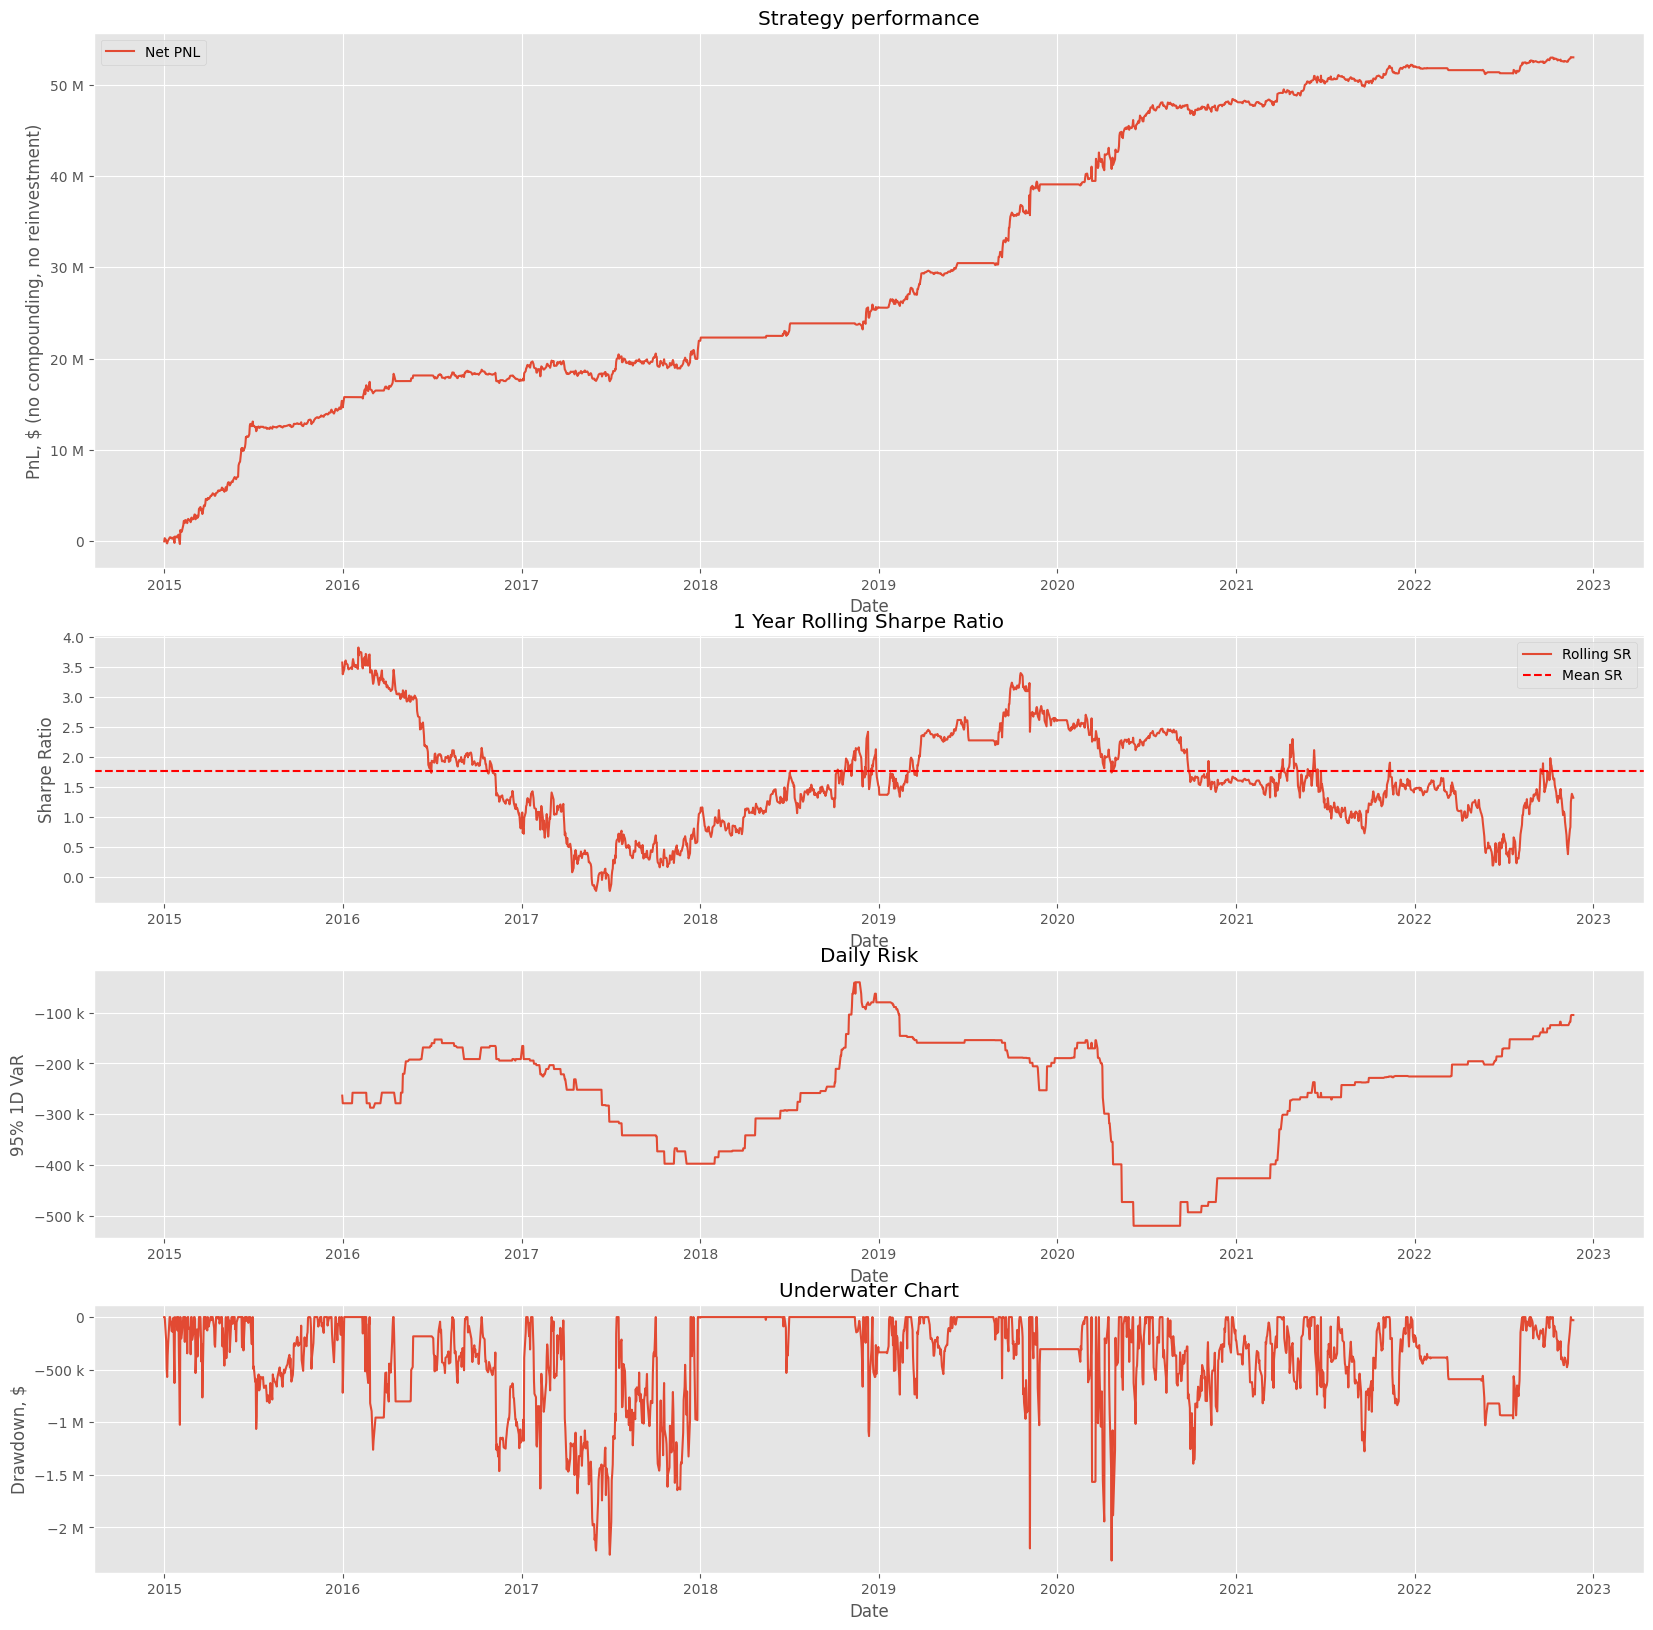

In [7]:
df_stats = plot_stats(pca_total_pnl, pca_trading)
df_stats.style.format("{:,.0f}") \
        .format("{:.2f}", subset=pd.IndexSlice[['Sharpe Ratio', 'Sortino Ratio'], :]) \
        .format("{:.2%}", subset=pd.IndexSlice[['Daily Turnover Ratio, %', 'Return on GMV, %'], :])

### Sensitivities and Strategy Tweaks
There are two important observations to be made from the results above. First, the strategy requires a high gross market value of positions. Second, the daily turnover of the strategy is also high. There are ways to reduce both of these figures to lower sensitivity to transaction costs and increase return on capital.

One effective approach is to decrease the frequency of rebalancing by allowing a reasonably small level of tracking error risk. Below is an analysis of the strategy's sensitivity to transaction costs at different levels of tracking error volatility buffers:

Aggregating Signals
Setting Target Volatility


100%|██████████| 2058/2058 [00:15<00:00, 133.79it/s]


Calculating Position


100%|██████████| 2057/2057 [04:25<00:00,  7.75it/s]


Calculating Position


100%|██████████| 2057/2057 [04:07<00:00,  8.32it/s]


Calculating Position


100%|██████████| 2057/2057 [03:07<00:00, 10.95it/s]


Calculating Position


100%|██████████| 2057/2057 [02:42<00:00, 12.64it/s]


Calculating Position


100%|██████████| 2057/2057 [02:26<00:00, 14.05it/s]


Calculating Position


100%|██████████| 2057/2057 [02:16<00:00, 15.11it/s]


Calculating Position


100%|██████████| 2057/2057 [02:02<00:00, 16.81it/s]


Calculating Position


100%|██████████| 2057/2057 [01:52<00:00, 18.31it/s]


,0.0,0.01,0.025,0.05,0.1,0.2,0.5,1.0,Best Sharpe
0.0,2.20,2.11,1.59,1.42,1.16,0.87,0.85,0.77,2.20
0.5,1.76,1.75,1.35,1.24,1.03,0.76,0.75,0.71,1.76
1.0,1.32,1.38,1.12,1.05,0.89,0.65,0.66,0.65,1.38
2.0,0.42,0.62,0.63,0.68,0.62,0.43,0.47,0.52,0.68


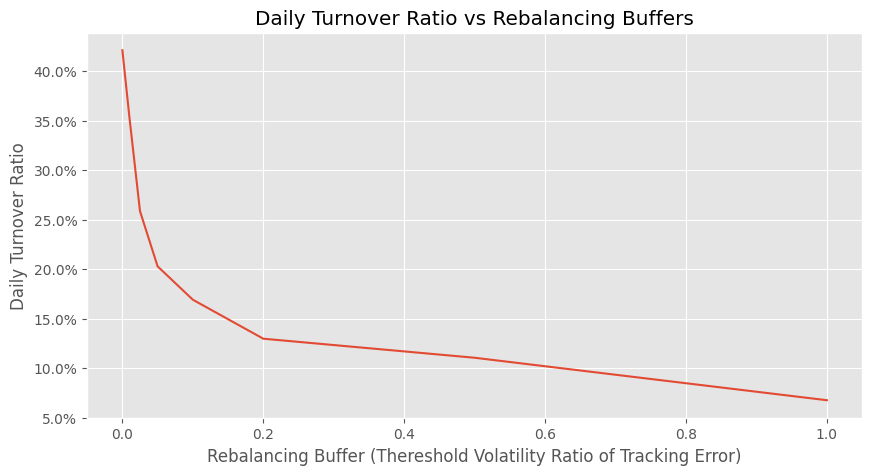

In [15]:
rebals = [0, 0.01, 0.025, 0.05, 0.1, 0.2, 0.5, 1]
tcosts = [0, 0.5, 1, 2]
sharpes = pd.DataFrame(index=tcosts, columns=rebals)
turnovers = pd.Series(index=rebals, dtype=float)
agg_strategy = AggregatedSignal([agg_butterflies, agg_spreads], dates=df_zc.loc['2015':].index)
agg_strategy.estimate_target_risk()
agg_strategy.set_target_volatility(1, df_zc)
for th in rebals:
    trading = SystematicStrategy(agg_strategy, df, price_data, df_zc, rebal_threshold=th, fit_resid=fit_data, time_slippage=1)
    trading.calc_position()
    trading.calc_total_pnl(tcosts[0]/10000)
    turnovers.loc[th] = (trading.trades * trading.dirty_prices).abs().sum(axis=1).sum() / \
        (trading.position * trading.dirty_prices).abs().sum(axis=1).sum()
    sharpes.loc[tcosts[0], th] = np.sqrt(261) * trading.pnl.sum(axis=1).mean() / trading.pnl.sum(axis=1).std()
    for tc in tcosts[1:]:
        trading.calc_total_pnl(tc/10000)
        sharpes.loc[tc, th] = np.sqrt(261) * trading.pnl.sum(axis=1).mean() / trading.pnl.sum(axis=1).std()
sharpes.columns = [str(c) for c in sharpes.columns]
sharpes.index = [str(c) for c in sharpes.index]
sharpes['Best Sharpe'] = sharpes.max(axis=1)

fig, ax = plt.subplots(1,1, figsize=(10,5))
ax.plot(turnovers)
ax.set_title('Daily Turnover Ratio vs Rebalancing Buffers')
ax.set_xlabel('Rebalancing Buffer (Threshold Volatility Ratio of Tracking Error)')
ax.set_ylabel('Daily Turnover Ratio')
ax.yaxis.set_major_formatter(ticker.PercentFormatter(xmax=1))

sharpes.style.format('{:,.2f}').set_properties(**{'background-color': 'grey'}).\
    highlight_max(axis=1, props='color:green;background-color:white').\
    set_caption("Sharpe Ratios for Different Costs and Rebalancing Buffers")

A larger buffer, through decreased turnover, results in a lower sensitivity to transaction costs. Furthermore, as transaction costs increase, the optimal buffer size also grows.


### Conclusion and Further work

I demonstrated how a systematic relative value strategy can be constructed in the MBONOs market. The strategy has a relatively high turnover, making it sensitive to transaction costs. I also showed how the strategy can be adjusted to accommodate higher costs while still maintaining an investable Sharpe ratio.

However, further work is needed on portfolio construction and rebalancing methods to reduce costs and capital utilization. Another important improvement is incorporating carry and roll-down analysis to minimize false positives, especially for steepener/flatteners trades. Following that, I plan to integrate the rate derivatives market into the framework to introduce additional dimensions for alpha opportunities and reduce capital requirements.